In this notebook, we examine the flow of a slightly more sophisticated compartmental model known as Susceptible-Exposed-Infected-Recovered (SEIR). This model is the next step in scaling up to more complicated population modeling, and provides an intuitive extension to SIR. Additionally, we also introduce here the u parameter, and how we can use it to observe how policy can impact the growth or decline of infection rate. 

As the name suggests, this probabilistic model has one additional factor after SIR. With that in mind, we now define the equations as follows:

$$
s(t) + e(t) + i(t) + r(t) = 1 \\
\frac{dS}{dt} = -\beta S(t) i(t) \\
\frac{dE}{dt} = \beta S(t) i(t) - \lambda_1 E(t) \\
\frac{dI}{dt} = \lambda_1 E(t) - \lambda_2 i(t)  \\
\frac{dR}{dt} = \lambda_2 i(t)
$$

The intuition behind this new compartment is that there is a significant incubation period for infections, where indivuals are not yet infections. It's using this exposed period that population cannot spread the disease, themselves, but will soon start showing symptoms and therefore move to the $I$ compartment. 


Using our Pyro chops, we could build this model from scratch in a manner very similar to the way we did for SIR, but instead we take advantage of Pyro's compartmental modules and can start from that. 

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
#assert pyro.__version__.startswith('1.5.0') # I have 1.5.1, hopefully not a problem to comment this out. 
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
pyro.enable_validation(True)  # Always a good idea.
smoke_test = ('CI' in os.environ)

In [6]:
class SimpleSEIRModel(CompartmentalModel):
    """
    Susceptible-Exposed-Infected-Recovered model.

    This is a stochastic discrete-time discrete-state model with four
    compartments: "S" for susceptible, "E" for exposed, "I" for infected,
    and "R" for recovered individuals (the recovered individuals are
    implicit: ``R = population - S - E - I``) with transitions
    ``S -> E -> I -> R``.

    :param int population: Total ``population = S + E + I + R``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
        
    NK: In our implementation we keep all the same, but now introduce u, 
    as previously discussed, as a means to demonstrate intervention efficacy. 
    """

    def __init__(self, population, incubation_time, recovery_time, data):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)

        assert isinstance(incubation_time, float)
        assert incubation_time > 1
        self.incubation_time = incubation_time

        assert isinstance(recovery_time, float)
        assert recovery_time > 1
        self.recovery_time = recovery_time

        self.data = data

    def global_model(self):
        tau_e = self.incubation_time
        tau_i = self.recovery_time
        
        R0 = pyro.sample("R0", dist.LogNormal(0., 1.))
        rho = pyro.sample("rho", dist.Beta(10, 10)) # noisy observations. Whatever the true number of infections is, will be something 
                                                    # scaled by this random variable rho. 
        
        u = pyro.sample("u", dist.Uniform(0, 0.85)) # it's unrealistic to get a u to high, so we set it as a value between 0 and 0.85.  

        return R0, tau_e, tau_i, rho,u

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, u  = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=(1 - u) * R0 / tau_i,   # As in SIR, scaled by 1-u for intervention
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_e))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau_i))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2E, rho),
                    obs=self.data[t] if t_is_observed else None)



With our class defined, the first thing we should do is test whether or not it works effectively by generating a sample trajectory. The way we do this is by initializing some values about the epidemic, and simulate.

In [7]:
population = 10000
recovery_time = 7.
duration = 300
empty_data = [None] * duration # fill this array if you wish to condition on real world data. 
incubation_time = 7.
model = SimpleSEIRModel(population, incubation_time,recovery_time, empty_data)


# We'll repeatedly generate data until a desired number of infections is found.
for attempt in range(100):
    synth_data = model.generate({"R0": 1.5,"u":.11}) # starting values for R0 and u. 
    total_infections = synth_data["S2E"].sum().item()
    print('total_infections:',total_infections)
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


Nice! It worked with only a few tries. Let's take a look.

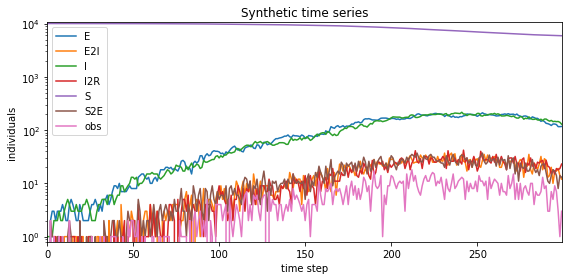

In [11]:
plt.figure(figsize=(8,4))
for name, value in sorted(synth_data.items()):
    if value.dim():
        plt.plot(value, label=name)
plt.xlim(0, len(empty_data) - 1)
plt.ylim(0.8, None)
plt.xlabel("time step")
plt.ylabel("individuals")
plt.yscale("log")
plt.legend(loc="best")
plt.title("Synthetic time series")
plt.tight_layout()

Next let's generate some more data, but this time, vary $u$ and examine how this impact the different compartments. 

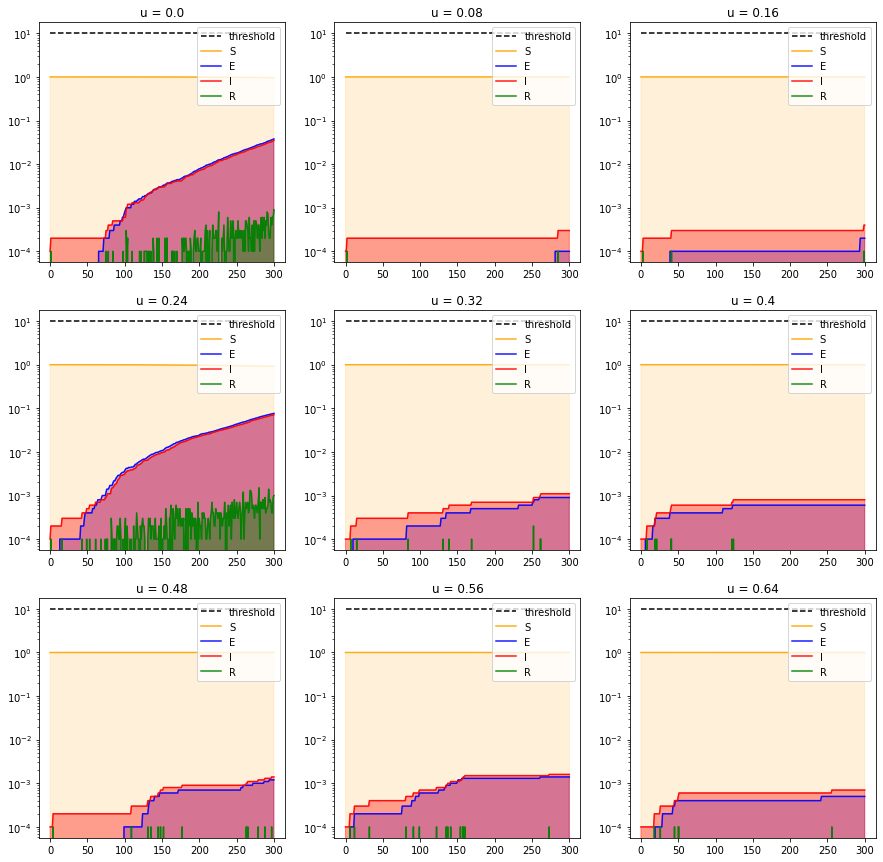

In [33]:
import numpy as np
fig, ax = plt.subplots(3,3, figsize=(15,15))
dummyu = np.arange(0, 0.8, 0.08)
count = 0 
for ii in range(3):   # since i is used for the compartmental model
    for j in range(3):
        u = dummyu[count]


        
        data = model.generate({"R0": 1.5,'u':u})


        _S = [population]
        _E = [0]
        _I = [1]
        _R = [0]

        for t in range(duration):
            s = _S[t] - data['S2E'][t]
            e = _E[t] + data['E2I'][t]
            i = _I[t] + data['I2R'][t]
            r = data['I2R'][t]
            _S.append(s)
            _E.append(e)
            _I.append(i)
            _R.append(r)
            
        _S = torch.tensor(_S)/population
        _E = torch.tensor(_E)/population
        _I = torch.tensor(_I)/population
        _R = torch.tensor(_R)/population
        x_vals = np.arange(0, len(_S), 1)  # length of all arrays is the same as duration
        
        ax[ii, j].set_yscale('log')        
        ax[ii, j].plot([population/1000]*len(_S), label='threshold', color='black', linestyle='dashed')
        ax[ii, j].plot(_S, label='S', color='orange', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _S, color='orange', alpha=0.15)
        ax[ii, j].plot(_E, label='E', color='blue', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _E, color='blue', alpha=0.25)
        ax[ii, j].plot(_I, label='I', color='red', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _I, color='red', alpha=0.35)
        ax[ii, j].plot(_R, label='R', color='green', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _R, color='green', alpha=0.45)
        ax[ii, j].legend(loc="upper right")
        ax[ii, j].set_title("u = {}".format(u))
        count += 1


As you can see, the greater the value of u, the flatter the curve!


In our next experiment, we will perform inference using SEIR and some synthetic data, and see what sort of posterior estimates it acquires.

For consistency, let's use the same data from before.

In [34]:
population = 10000
recovery_time = 7.
duration = 300
empty_data = [None] * duration # fill this array if you wish to condition on real world data. 
incubation_time = 7.
model = SimpleSEIRModel(population, incubation_time,recovery_time, empty_data)


# We'll repeatedly generate data until a desired number of infections is found.
for attempt in range(100):
    synth_data = model.generate({"R0": 1.5,"u":.11}) # starting values for R0 and u. 
    total_infections = synth_data["S2E"].sum().item()
    print('total_infections:',total_infections)
    if 4000 <= total_infections <= 6000:
        break
print("Simulated {} infections after {} attempts".format(total_infections, 1 + attempt))


total_infections: 4275.0
Simulated 4275.0 infections after 1 attempts


In [35]:
# we re-initialize our model, now using the data we observed.

obs = synth_data["obs"]
model = SimpleSEIRModel(population, incubation_time, recovery_time, obs) 


In [47]:
%%time
mcmc = model.fit_mcmc(num_samples=4 if smoke_test else 1000,
                      jit_compile=True,)

INFO 	 Running inference...
Sample: 100%|██████████| 2000/2000 [03:44,  8.92it/s, step size=1.98e-02, acc. prob=0.797]

CPU times: user 3min 40s, sys: 321 ms, total: 3min 40s
Wall time: 3min 44s


In [49]:
%%time
samples = model.predict()

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 783 ms, sys: 40.8 ms, total: 824 ms
Wall time: 830 ms


In [50]:
for key, value in sorted(samples.items()):
    print("{}.shape = {}".format(key, tuple(value.shape)))

E.shape = (1000, 300)
E2I.shape = (1000, 300)
I.shape = (1000, 300)
I2R.shape = (1000, 300)
R0.shape = (1000, 1)
S.shape = (1000, 300)
S2E.shape = (1000, 300)
auxiliary.shape = (1000, 1, 3, 300)
obs.shape = (1000, 300)
rho.shape = (1000, 1)
u.shape = (1000, 1)


/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/scratch/nsk367/anaconda3/envs/pyro/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

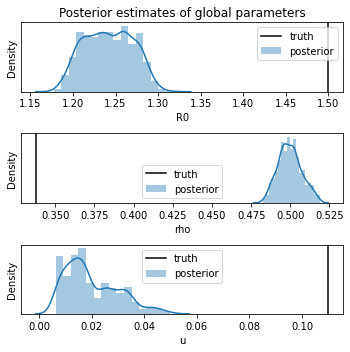

In [51]:
names = ["R0", "rho","u"]
fig, axes = plt.subplots(3, 1, figsize=(5, 5))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    truth = synth_data[name]
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(truth, color="k", label="truth")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
plt.tight_layout()


The posterior estimate for u is poor, but this is acceptable when you consider how the value for R0 is also under-estimated. Based on the equations, this makes sense, because we expect u to create an effectively smaller value for R0, and this is what we recover. 

Furthermore, we can forecast using this model.

INFO 	 Predicting latent variables for 300 time steps...


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


INFO 	 Forecasting 30 steps ahead...


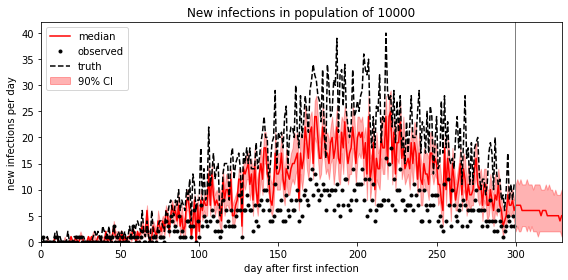

In [46]:
%time
samples = model.predict(forecast=30)

def plot_forecast(samples):
    duration = len(empty_data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])

    time = torch.arange(duration + forecast)
    S2E = samples["S2E"]
    median = S2E.median(dim=0).values
    p05 = S2E.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2E.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    plt.figure(figsize=(8, 4))
    plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    plt.plot(time, median, "r-", label="median")
    plt.plot(time[:duration], obs, "k.", label="observed")
    plt.plot(time[:duration], synth_data["S2E"], "k--", label="truth")
    plt.axvline(duration - 0.5, color="gray", lw=1)
    plt.xlim(0, len(time) - 1)
    plt.ylim(0, None)
    plt.xlabel("day after first infection")
    plt.ylabel("new infections per day")
    plt.title("New infections in population of {}".format(population))
    plt.legend(loc="upper left")
    plt.tight_layout()

plot_forecast(samples)